## <font color='coral'>**Appel de l'environment** </font>

In [1]:
%reset -f
import ipywidgets as widgets
%matplotlib widget

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from IPython.display import clear_output
from RVutils import *
from scipy import special
import scipy.integrate as integrate
from scipy.misc import derivative

## For sliders
from ipywidgets import Layout, interact

## Set up rc
plt.rcParams['image.cmap'] = 'RdYlBu_r'
plt.rcParams['axes.formatter.limits'] = (-3,1)
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams.update({"axes.grid" : True})
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.markeredgewidth'] = 2.0
plt.rc('font',size=18)
me = (0.1,0.1) #Markevery

## <font color='coral'>**Chargement des données** </font>

In [2]:
data = np.loadtxt('data_exp/exp_profs_45333.dat')
data_q = np.loadtxt('data_exp/exp_profs_q_45333.dat')

data_exp = np.vstack((data,data_q))

param = ['rho','nustar_lowq','nustar_highq','eps','delta','q_lowq','q_highq']
data_dic  = {}
for ip,p in enumerate(param):
    data_dic[p] = data_exp[ip,:]

## <font color='coral'>**Defining collisional functions** </font>

In [4]:
# %% Collisions related functions
def Phi_v(v)   : return (2/(np.sqrt(np.pi))) * integrate.quad(lambda x: np.exp(-x**2),0,v)[0]
def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))
def nu_bar_v(v): return 0.75*np.sqrt(2*np.pi) * v**(-3) * (Phi_v(v) - G_v(v))
def nu_bar_u(u): return nu_bar_v(np.sqrt(u))

# %% Regime discrimination functions
def min_ap(x,y): return x*y/(x+y)
def max_ap(x,y): return x+y

## Some usefull parameters
I=(4 * 1.38 / np.pi)
sp2 = np.sqrt(np.pi/2)

res = 300
axe_theta = np.linspace(0,2*np.pi,res)
ulim=20

## kT, kE, kP
def kT_kE_kP_new(DoE, nustar, Nq):
    
    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
            G0         +=0
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    K_u       = 0
    K_hat_u   = 0
    K_tilde_u = 0
    
    d       = np.zeros(3)
    d_tilde = np.zeros(3)
    d_hat   = np.zeros(3)
    
    vres    = 100
    for u in np.linspace(0.01,20,vres):
        K_u       = sp2 * np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u))
        K_tilde_u = (2/np.pi)**(1.5)*(1/nustar)*np.exp(-u) * u**(5/2)/nu_bar_u(u)* (\
                        (32/9)* G1  \
                        +2*(1/(Nq))*DoE**2 * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)))
        K_hat_u   = sp2 * Nq * np.exp(-u) * u**2 * (G0 + min_ap( G0_prime, G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u)))
        
        for n in range(3):
            d[n]       += (u-1.5)**n * K_u
            d_tilde[n] += (u-1.5)**n * K_tilde_u 
            d_hat[n]   += (u-1.5)**n * K_hat_u 

    Delta = (d[0] + d_tilde[0])*(d[0] + d_hat[0])-d[0]**2 
            
    k_T = (d[0] * d_tilde[1] - d[1] * d_tilde[0])  /Delta
    k_E = ((d[0] + d_hat[0])*(d[1] + d_tilde[1]) - d[0]*d[1]) /Delta
    k_P = 1 + k_T - k_E
    return k_T, k_E, k_P

## <font color='coral'>**Plot profiles** </font>

C:\Users\RV273815\AppData\Local\Temp\ipykernel_10740\3163083980.py:15: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(data_dic['rho'],data_dic['delta']/data_dic['eps'],'k-',label=r'$\delta/\epsilon$')


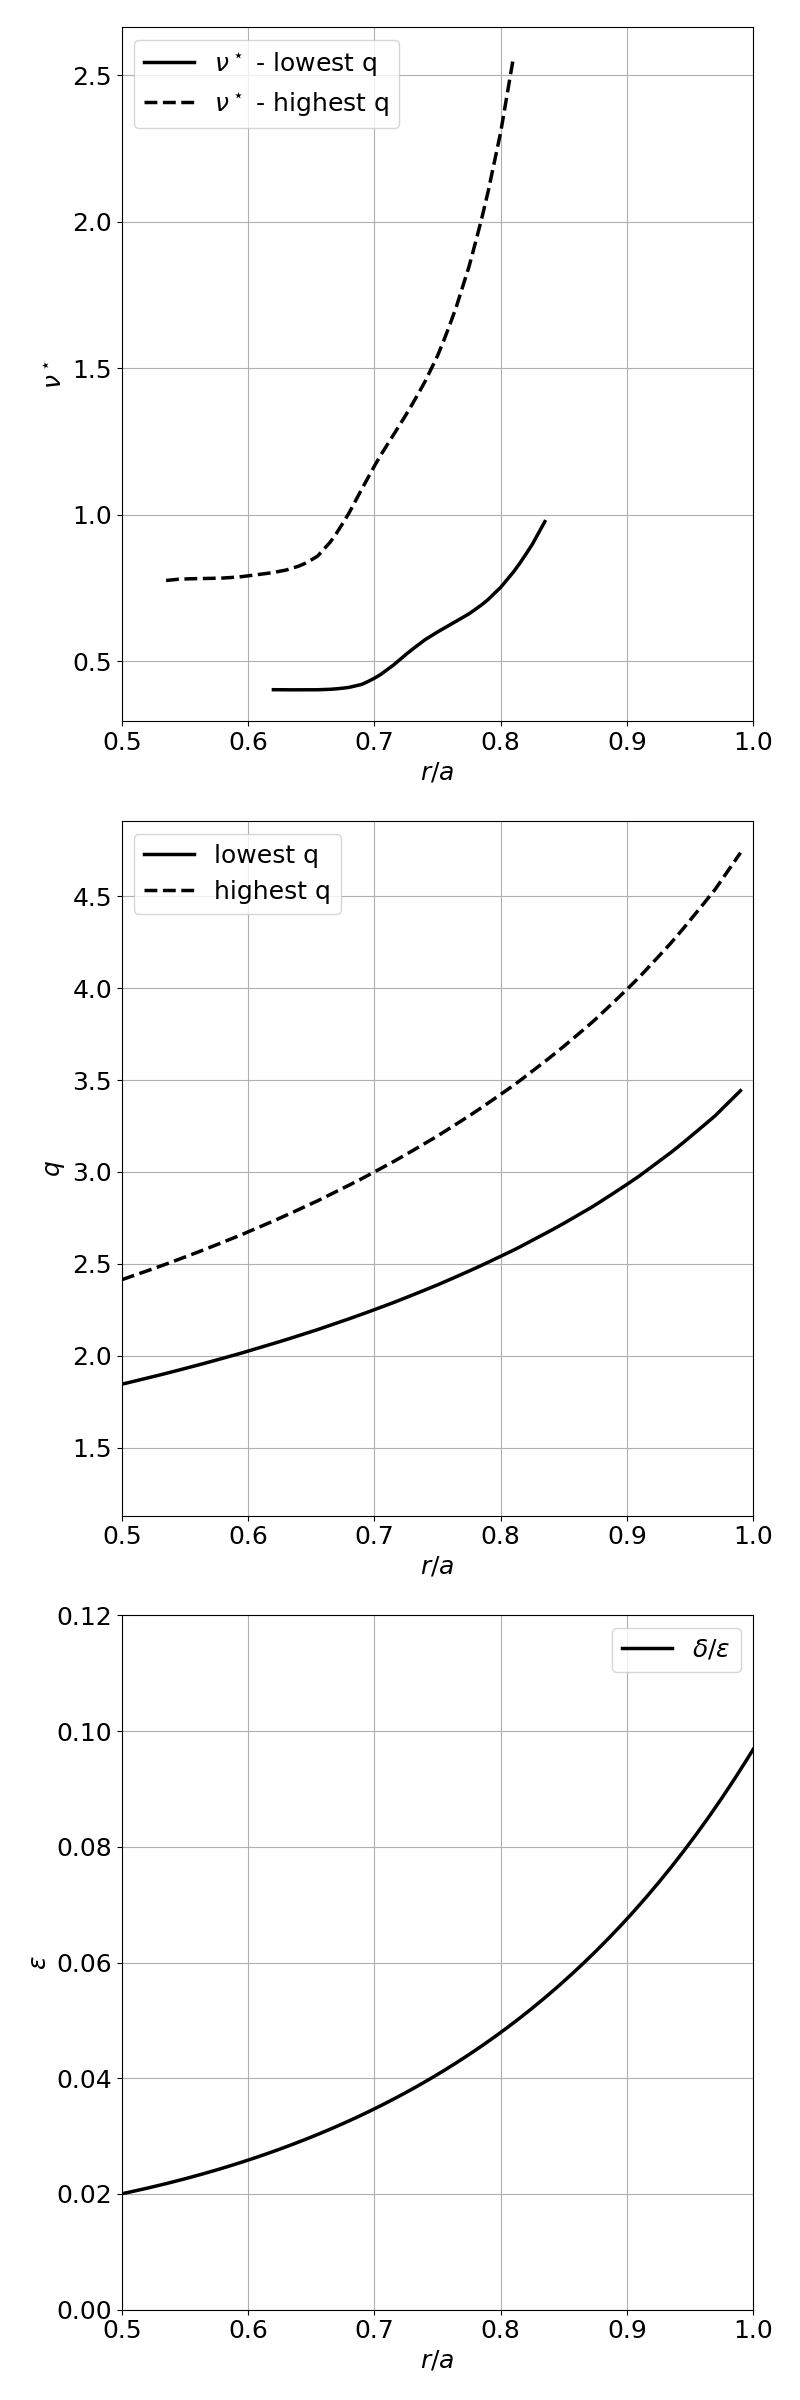

In [6]:
clear_output(wait=True)

fig = plt.figure(figsize=(8,24))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(313)
ax3 = fig.add_subplot(312)


ax1.plot(data_dic['rho'],data_dic['nustar_lowq'],'k-',label=r'$\nu^\star$ - lowest q')
ax1.plot(data_dic['rho'],data_dic['nustar_highq'],'k--',label=r'$\nu^\star$ - highest q')
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$\nu^\star}$')
ax1.legend(loc='best')

ax2.plot(data_dic['rho'],data_dic['delta']/data_dic['eps'],'k-',label=r'$\delta/\epsilon$')
# ax2.plot(data_dic['rho'],data_dic['delta'],'k-',label=r'$\delta$')
# ax2.plot(data_dic['rho'],data_dic['eps'],'k--',label=r'$\epsilon$')
ax2.set_xlabel(r'$r/a$')
ax2.set_ylabel(r'$\epsilon$')
ax2.legend(loc='best')
ax2.set_ylim(0,0.12)

ax3.plot(data_dic['rho'],data_dic['q_lowq'],'k-',label=r'lowest q')
ax3.plot(data_dic['rho'],data_dic['q_highq'],'k--',label=r'highest q')
ax3.set_xlabel(r'$r/a$')
ax3.set_ylabel(r'$q$')
ax3.legend(loc='best')

for axes in [ax1,ax2,ax3]:
    axes.set_xlim(0.5,1)

fig.tight_layout()

## <font color='coral'>**Calculating $k_E$ profile for experimental discharges** </font>

In [5]:
kE_ar1 = np.zeros(len(data_dic['rho']))
kE_ar2 = np.zeros(len(data_dic['rho']))

N=18

for il,(rho,nu1,nu2,eps,delta,q1,q2) in enumerate(zip(data_dic['rho'],data_dic['nustar_lowq'],data_dic['nustar_highq'],data_dic['eps'],data_dic['delta'],data_dic['q_lowq'],data_dic['q_highq'])):
    # print(nu1,nu2)
    if not(np.isnan(rho) or np.isnan(nu1) or np.isnan(nu2) or np.isnan(eps) or np.isnan(delta) or np.isnan(q1) or np.isnan(q2)):
        kE_ar1[il]=kT_kE_kP_new(delta/eps,nu1,N*q1)[1]
        kE_ar2[il]=kT_kE_kP_new(delta/eps,nu2,N*q2)[1]
    # print(il)
    # print(kE_ar1[il])
    # print(kE_ar2[il])

#print(kE_ar1)


C:\Users\RV273815\AppData\Local\Temp\ipykernel_13556\3259788412.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))
C:\Users\RV273815\AppData\Local\Temp\ipykernel_13556\3259788412.py:8: RuntimeWarning: invalid value encountered in double_scalars
  def min_ap(x,y): return x*y/(x+y)
C:\Users\RV273815\AppData\Local\Temp\ipykernel_13556\3259788412.py:45: RuntimeWarning: invalid value encountered in double_scalars
  K_tilde_u = (2/np.pi)**(1.5)*(1/nustar)*np.exp(-u) * u**(5/2)/nu_bar_u(u)* (\


## <font color='green'>**(TSVV Workshop)** </font> <font color='coral'>**Plotting $k_E$ profile for experimental discharges** </font>

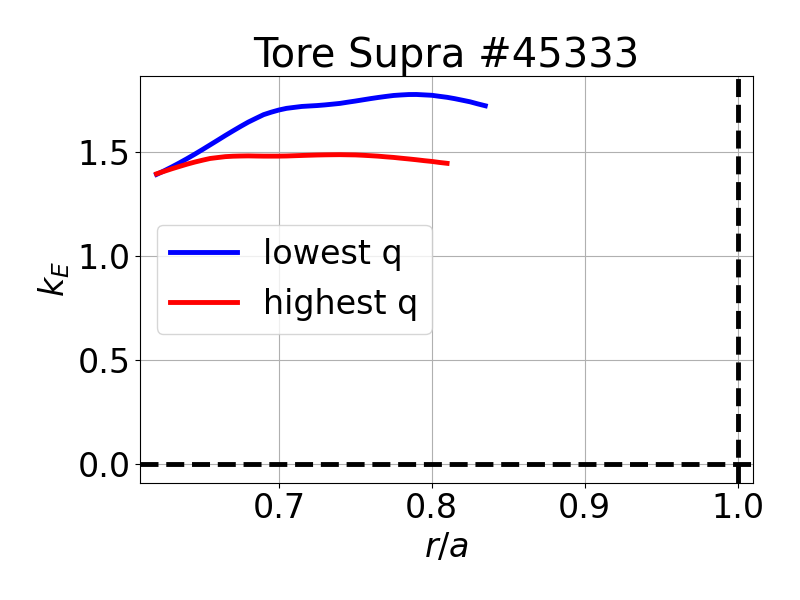

In [8]:
clear_output(wait=True)

plt.rcParams['lines.linewidth'] = 3.5
plt.rc('font',size=24)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(data_dic['rho'][kE_ar1>0],kE_ar1[kE_ar1>0],'b',label=r'lowest q')
ax1.plot(data_dic['rho'][kE_ar1>0],kE_ar2[kE_ar1>0],'r',label=r'highest q')
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$k_E$')
ax1.legend(loc='center left')
ax1.set_xlim(right=1.01)
ax1.set_title(r'Tore Supra #45333')

ax1.axhline(0.0,color='k',linestyle='--')
ax1.axvline(1.0,color='k',linestyle='--')

fig.tight_layout()

## Export rho and kE as .dat
np.savetxt('data_exp/kE_45333.dat',[data_dic['rho'],kE_ar1,kE_ar2])

# np.savetxt('data_exp/exp_profs_45333.dat')
# data_q = np.loadtxt('data_exp/exp_profs_q_45333.dat')

## <font color='coral'>**(Maybe not useful) Differentiating TS and WEST ripple** </font>

In [ ]:
def calculate_ripple_amplitude_TS(rho, theta):
    # Paramètres Tore Supra
    R0    = 2.3946       #Grand rayon
    Eps   = 3.2          #Rapport d'aspect
    a     = R0/Eps       #Petit rayon
    N     = 18           #Nombre de bobines
    Eps_b = 1.267/2.3946 #Rapport du diamètre moyen des bobines sur le grand rayon
    L0 = 0.5*R0* ( 1 - np.sqrt(1 - 2*(Eps_b**2) ) )   #cf Rapport de stage Varennes 2018
    delta_n = 9.8559e-5 #Paramètre ajusté pour coller au mieux à la thèse de Grua pour N=18

    # Calcul de l'amplitude ripple
    r = rho*a
    cos = np.cos(theta)
    R = R0 + r*cos
    rprime = np.sqrt( 2*(R0-L0)* ( R - np.sqrt(R**2 - r**2 - L0**2 - 2*r*L0*cos) ) )
    ripple_TS_amp = delta_n * special.iv(0, N * rprime / (R0-L0) ) #special.iv(0,x) : fonction de Bessel modifiée de première espèce d'ordre 0
    
    return ripple_TS_amp

def TS_ripple_FSavg(rho):
    # Paramètres Tore Supra
    R0    = 2.3946       #Grand rayon
    Eps   = 3.2          #Rapport d'aspect
    a     = R0/Eps       #Petit rayon
    N     = 18           #Nombre de bobines
    Eps_b = 1.267/2.3946 #Rapport du diamètre moyen des bobines sur le grand rayon
    L0 = 0.5*R0* ( 1 - np.sqrt(1 - 2*(Eps_b**2) ) )   #cf Rapport de stage Varennes 2018
    delta_n = 9.8559e-5 #Paramètre ajusté pour coller au mieux à la thèse de Grua pour N=18

    # Calcul de l'amplitude ripple
    r = rho*a
    theta_ar = np.linspace(0,2*np.pi,100)
    ripple_TS_amp = np.zeros(len(theta_ar))
    for ith,theta in enumerate(theta_ar):
        cos = np.cos(theta)
        R = R0 + r*cos
        rprime = np.sqrt( 2*(R0-L0)* ( R - np.sqrt(R**2 - r**2 - L0**2 - 2*r*L0*cos) ) )
        ripple_TS_amp[ith] = delta_n * special.iv(0, N * rprime / (R0-L0) ) 
    return np.mean(ripple_TS_amp,axis=0)

print(TS_ripple_FSavg(0.5))

rho_ar = np.linspace(0.1,1.0,100)
